In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import json
import random
import matplotlib.pyplot as plt

In [26]:
seed = 9
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

batch_size = 128
num_epochs = 99
context_len = 128
initial_lr = 0.001
data_path = "./data/chinese-poetry/唐诗"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("now using", device)

now using cuda


## Self-Attention

In [27]:
x = torch.rand(1, 3, 5)
print(x)
raw_weights = torch.bmm(x, x.transpose(1, 2))
print(raw_weights)
weights = F.softmax(raw_weights, dim=2)
print(weights)
y = torch.bmm(weights, x)
print(y)

tensor([[[0.6558, 0.3020, 0.4799, 0.7774, 0.9180],
         [0.9310, 0.2604, 0.9534, 0.3804, 0.4104],
         [0.9510, 0.5686, 0.1381, 0.2069, 0.5139]]])
tensor([[[2.1985, 1.8192, 1.4942],
         [1.8192, 2.1568, 1.4548],
         [1.4942, 1.4548, 1.5537]]])
tensor([[[0.4590, 0.3141, 0.2269],
         [0.3230, 0.4527, 0.2243],
         [0.3308, 0.3180, 0.3511]]])
tensor([[[0.8092, 0.3494, 0.5511, 0.5232, 0.6669],
         [0.8466, 0.3430, 0.6176, 0.4697, 0.5976],
         [0.8470, 0.3824, 0.5105, 0.4508, 0.6147]]])


In [28]:
with open("poems.json", "r", encoding="utf-8") as f:
    poems = json.load(f)

with open("vocab.json", "r", encoding="utf-8") as f:
    word_to_index = json.load(f)

index_to_word = {index: word for word, index in word_to_index.items()}

vocab_size = len(word_to_index)

print("VOCAB_SIZE:", vocab_size)
print("data_size", len(poems))


# 将句子转换为列表形式，并添加结束符
poems = [list(poem) + ["<EOP>"] for poem in poems]
index_tensors = {
    word: torch.LongTensor([word_to_index[word]]) for word in word_to_index
}

VOCAB_SIZE: 3482
data_size 1287


In [29]:
def generate_sample(sequence):

    inputs = [index_tensors[sequence[i - 1]] for i in range(1, len(sequence))]
    outputs = [index_tensors[sequence[i]] for i in range(1, len(sequence))]

    # 将输入和输出列表合并为张量
    encoded_inputs = torch.cat(inputs)
    encoded_outputs = torch.cat(outputs)

    return encoded_inputs, encoded_outputs


class PoetryDataset(Dataset):
    def __init__(self, poems, transform=None):
        self.poems = poems
        self.transform = transform

    def __len__(self):
        return len(self.poems)

    def __getitem__(self, index):
        poem = self.poems[index]
        input_data, output_data = generate_sample(poem)
        if self.transform:
            input_data = self.transform(input_data)
        return input_data, output_data


def custom_collate_fn(batch):
    sequences, targets = zip(*batch)
    # 统一长度以进行批处理
    padded_sequences = nn.utils.rnn.pad_sequence(
        sequences, batch_first=True, padding_value=word_to_index["<START>"]
    )
    padded_targets = nn.utils.rnn.pad_sequence(
        targets, batch_first=True, padding_value=word_to_index["<START>"]
    )
    return padded_sequences, padded_targets


dataset = PoetryDataset(poems)
data_loader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn
)

![](../multi-head.png)

![](../self-attention.png)


In [30]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, num_heads=4, mask=False):
        super(SelfAttention, self).__init__()

        assert embed_size % num_heads == 0, "Embedding size 必须是 heads 的整数倍"
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        # 计算所有 heads 的 query, key 和 value
        self.query_projection = nn.Linear(embed_size, embed_size, bias=False)
        self.key_projection = nn.Linear(embed_size, embed_size, bias=False)
        self.value_projection = nn.Linear(embed_size, embed_size, bias=False)

        # 在 multi-head self-attention 操作后应用
        self.fc_out = nn.Linear(embed_size, embed_size)
        self.mask = mask

    def forward(self, x):
        batch_size, seq_length, embed_size = x.size()

        # 计算所有 heads 的 query, key 和 value
        queries = self.query_projection(x).view(
            batch_size, seq_length, self.num_heads, self.head_dim
        )
        keys = self.key_projection(x).view(
            batch_size, seq_length, self.num_heads, self.head_dim
        )
        values = self.value_projection(x).view(
            batch_size, seq_length, self.num_heads, self.head_dim
        )

        # 将 tensor 重新排列，以适应 multi-head attention
        queries = (
            queries.transpose(1, 2)
            .contiguous()
            .view(batch_size * self.num_heads, seq_length, self.head_dim)
        )
        keys = (
            keys.transpose(1, 2)
            .contiguous()
            .view(batch_size * self.num_heads, seq_length, self.head_dim)
        )
        values = (
            values.transpose(1, 2)
            .contiguous()
            .view(batch_size * self.num_heads, seq_length, self.head_dim)
        )

        # 计算 Scaled dot-product attention
        dot_product = torch.bmm(queries, keys.transpose(1, 2))
        scaled_dot_product = dot_product / (self.embed_size**0.5)

        # 如果启用了 mask，则对未来的 token 进行屏蔽
        if self.mask:
            mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool()
            mask = mask.to(device)
            scaled_dot_product.masked_fill_(mask, float("-inf"))

        attention = F.softmax(scaled_dot_product, dim=2)

        # 将 self-attention 应用于 values
        out = torch.bmm(attention, values).view(
            batch_size, self.num_heads, seq_length, self.head_dim
        )
        out = (
            out.transpose(1, 2)
            .contiguous()
            .view(batch_size, seq_length, self.embed_size)
        )

        return self.fc_out(out)

![](../transformer-architecture.png)


In [31]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, mask=False):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_size, num_heads=num_heads, mask=mask)
        self.norm1 = nn.LayerNorm(embed_size)
        self.ff = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )
        self.norm2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        # Self-attention 和残差连接
        attended = self.attention(x)
        x = self.norm1(attended + x)

        # 前馈神经网络和残差连接
        fedforward = self.ff(x)
        return self.norm2(fedforward + x)

In [32]:
class Transformer(nn.Module):
    def __init__(
        self,
        embed_size,
        num_heads,
        num_layers,
        seq_length,
        num_tokens,
        num_classes,
        mask=False,
    ):
        super(Transformer, self).__init__()

        self.token_emb = nn.Embedding(num_tokens, embed_size)
        self.pos_emb = nn.Embedding(seq_length, embed_size)

        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, num_heads, mask) for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        """
        :param x: A (batch_size, seq_length) tensor of integer values representing words (in some predetermined vocabulary).
        :return: A (batch_size, num_classes) tensor of log-probabilities over the classes.
        """
        batch_size, seq_length = x.size()

        # 生成 token 嵌入
        tokens = self.token_emb(x)

        # 生成位置嵌入
        positions = torch.arange(seq_length).to(x.device)
        positions = self.pos_emb(positions).expand(batch_size, seq_length, -1)

        # 将 token 嵌入和位置嵌入相加
        x = tokens + positions

        # 通过所有 Transformer 层
        for layer in self.layers:
            x = layer(x)

        # 最后映射到类概率
        x = self.fc_out(x)

        return x

In [33]:
def train(model, data_loader, num_epochs, device, optimizer, criterion, scheduler):
    log_dict = {
        "train_loss_per_epoch": [],
        "train_perplexity_per_epoch": [],
    }
    start_time = time.time()
    model = model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Current Learning Rate: {current_lr:.6f}"
        )
        total_loss = 0
        model.train()
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)

            if not batch_idx % 5:
                print(
                    f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | Batch {batch_idx:04d}/{len(data_loader):04d} | Loss: {loss:.6f}"
                )

        avg_loss = total_loss / len(data_loader.dataset)
        scheduler.step(avg_loss)
        perplexity = torch.exp(torch.tensor(avg_loss))
        log_dict["train_loss_per_epoch"].append(avg_loss)
        log_dict["train_perplexity_per_epoch"].append(perplexity)

        print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

    torch.save(model.state_dict(), "model_state_dict.pth")
    print(f"Total Training Time: {(time.time() - start_time)/ 60:.2f} min")
    return log_dict

Epoch: 001/099 | Current Learning Rate: 0.001000
Epoch: 001/099 | Batch 0000/0011 | Loss: 8.315066
Epoch: 001/099 | Batch 0005/0011 | Loss: 6.861682
Epoch: 001/099 | Batch 0010/0011 | Loss: 6.424147
Time elapsed: 0.05 min
Epoch: 002/099 | Current Learning Rate: 0.001000
Epoch: 002/099 | Batch 0000/0011 | Loss: 6.162871
Epoch: 002/099 | Batch 0005/0011 | Loss: 5.975317
Epoch: 002/099 | Batch 0010/0011 | Loss: 5.949717
Time elapsed: 0.09 min
Epoch: 003/099 | Current Learning Rate: 0.001000
Epoch: 003/099 | Batch 0000/0011 | Loss: 5.863642
Epoch: 003/099 | Batch 0005/0011 | Loss: 5.825285
Epoch: 003/099 | Batch 0010/0011 | Loss: 5.887747
Time elapsed: 0.14 min
Epoch: 004/099 | Current Learning Rate: 0.001000
Epoch: 004/099 | Batch 0000/0011 | Loss: 5.729217
Epoch: 004/099 | Batch 0005/0011 | Loss: 5.755128
Epoch: 004/099 | Batch 0010/0011 | Loss: 5.412067
Time elapsed: 0.18 min
Epoch: 005/099 | Current Learning Rate: 0.001000
Epoch: 005/099 | Batch 0000/0011 | Loss: 5.743447
Epoch: 005/09

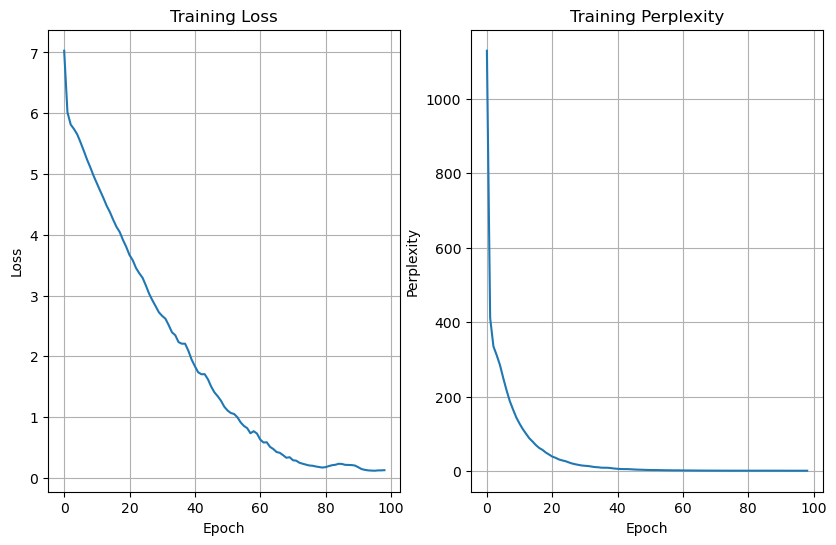

Transformer(
  (token_emb): Embedding(3482, 256)
  (pos_emb): Embedding(128, 256)
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): SelfAttention(
        (query_projection): Linear(in_features=256, out_features=256, bias=False)
        (key_projection): Linear(in_features=256, out_features=256, bias=False)
        (value_projection): Linear(in_features=256, out_features=256, bias=False)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc_out): Linear(in_features=256, out_features=3482, bias=True)
)

In [34]:
def plot_training_stats(log_dict):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(log_dict["train_loss_per_epoch"], label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(log_dict["train_perplexity_per_epoch"], label="Training Perplexity")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.grid(True)
    # plt.yscale("log")
    plt.title("Training Perplexity")
    plt.savefig("training_stats.svg")
    plt.show()


mask = True
model = Transformer(
    embed_size=256,
    num_heads=4,
    num_layers=8,
    seq_length=context_len,
    num_tokens=vocab_size,
    num_classes=vocab_size,
    mask=True,
)

optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=9, verbose=True
)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index["<START>"])
log_dict = train(
    model, data_loader, num_epochs, device, optimizer, criterion, scheduler
)
plot_training_stats(log_dict)
model.load_state_dict(torch.load("model_state_dict.pth"))
model.to(device)

In [53]:
def generate_text(start_word, top_k=1, temperature=0.7, log=False):
    generated_text = ""
    index_tensors_list = []
    for word in start_word:
        index_tensors_list.append(index_tensors[word].unsqueeze(0))
        generated_text += word
    model.eval()
    with torch.no_grad():
        for _ in range(context_len - len(generated_text)):
            input_tensor = torch.tensor(index_tensors_list).unsqueeze(0).to(device)
            output = model(input_tensor.to(device))

            last_word = output[:, -1, :]
            last_word = last_word.view(-1)

            # 调整温度
            # softmax 函数倾向于增强输入向量中最大值的影响
            scaled_logits = last_word / temperature
            probabilities = F.softmax(scaled_logits, dim=-1)

            probabilities, top_indices = probabilities.data.topk(top_k)
            top_words = [index_to_word[index.item()] for index in top_indices]
            probabilities = probabilities / torch.sum(probabilities)

            probabilities_np = probabilities.cpu().detach().numpy()
            indices_np = top_indices.cpu().detach().numpy()
            if log:
                for word, prob in zip(top_words, probabilities_np):
                    print(f"{word}: {prob:.4f}")

            selected_index = np.random.choice(indices_np, p=probabilities_np)

            next_word = index_to_word[selected_index]
            if next_word == "<EOP>":
                break
            if log:
                print(generated_text)
            index_tensors_list.append(index_tensors[next_word])
            generated_text += next_word

    return generated_text.strip()


print(generate_text("长安一片月", top_k=1))
for i in range(10):
    print(generate_text("月", top_k=20, temperature=1.1))
for i in range(10):
    print(generate_text("海", top_k=3))
print(generate_text("风", top_k=40))

长安一片月，万户捣衣声。秋风吹不尽，总是玉关情。何日平胡虏。良人罢远征。
月皎昭阳殿，冰清长信宫。天行乘玉辇，飞燕与君同。更有欢娱处，承恩乐未穷。相留未忍去，独坐怨秋风。
月落汉阳殿，风流天下芳。那堪荣未解，落花下珠袍。别有桂色尽，投竿也未调。相思不敢生，沙明千万族。
月宿金陵夜，风物何处枝。烟波写万户，锦幛一枝波。中有愿乘鸾，箫楼见溟渤。谁怜花一去，吾于尔谁闻。
月露，幽金，空落梅花酒。大嫂采掇玉，不歇巢何苦。不知彩云色，双行不可见。偏自入归日，清晖不肯分。
月皎昭阳殿，霜清长信宫。天行乘玉辇，飞燕与君同。更有留情处，承恩乐未穷。谁怜团扇妾，独坐怨秋风。
月皎昭阳殿，霜清长信宫。天行乘玉辇，飞燕与君同。更有留情处，承恩乐未忍。谁怜团扇妾，独坐怨秋风。
月皎昭阳殿，霜清长信宫。天行乘玉辇，飞燕与君同。更有留月余，承恩乐未央。一误云路远，独自月中杯。
月殿移公府，会带风吹台。吹云迎初尽，何如听蝉秋。借我生树嫩，童稚开荆末。却将添二子，清露催寒凝。
月皎昭阳殿，霜清长信宫。天行乘玉辇，飞燕与尔追。更有留情处，承恩乐未穷。谁怜团扇妾，独坐怨秋风。
月色不可扫，客愁不可道。玉露生秋衣，流萤飞百草。日月终销毁，天地各已衰。吾鸣此难追，飞日玉与憎。金丹宁误俗，昧者莫得奇。尔非千岁翁饮洲畔清且安。饮酒入玉壶，藏身以为宝。
海客乘天风，将船远行役。譬如云中鸟，一去无踪迹。
海水昔飞动，三龙纷战争。钟山危波澜，倾侧骇奔鲸。黄旗一扫荡，割壤开吴京。六代更霸王，遗迹见都城。至今秦淮间，礼乐秀群英。地扇邹鲁学，诗腾颜谢名。五月金陵西，祖余白下啸。欲寻庐峰顶，先遶汉水行。香炉紫烟灭，瀑布落太清。若攀星辰去，挥手缅含情。
海客乘天风，将船远行役。譬如云中鸟，一去无踪迹。
海水昔飞动，三龙纷战争。钟山危波澜，倾侧骇奔鲸。黄旗一扫荡，割壤开吴京。六代更霸王，遗迹见新知。至今秦淮间，礼乐秀群英。地扇邹鲁学，诗腾颜谢名。五月金陵西，祖余白下啸。欲寻庐峰顶，先遶汉水行。香炉紫烟灭，瀑布落太清。若攀星辰去，挥手缅含情。
海水昔飞动，三龙纷战争。钟山危波澜，倾侧骇奔鲸。黄旗一扫荡，割壤开吴京。六代更霸王，遗迹见都城。至今秦淮间，礼乐秀群英。地扇邹鲁学，诗腾颜谢名。五月金陵西，祖余白下啸。欲寻庐峰顶，先遶汉水行。香炉紫烟灭，瀑布落太清。若攀星辰去，挥手缅含情。
海水不满眼，观涛难称心。即知蓬莱石，却是巨鼇簪。

In [46]:
def generate_acrostic(start_word, top_k=1, temperature=0.7, log=False):
    generated_text = ""
    words = []
    for word in start_word:
        words += [word]
    index_tensors_list = []
    index_tensors_list.append(index_tensors[words[0]].unsqueeze(0))
    generated_text += words[0]
    model.eval()
    with torch.no_grad():

        ind = 1
        for _ in range(context_len - len(generated_text)):
            input = torch.tensor(index_tensors_list).unsqueeze(0).to(device)
            output = model(input)
            last_word = output[:, -1, :]
            last_word = last_word.view(-1)

            # 调整温度
            # softmax 函数倾向于增强输入向量中最大值的影响
            scaled_logits = last_word / temperature
            probabilities = F.softmax(scaled_logits, dim=-1)

            probabilities, top_indices = probabilities.data.topk(top_k)
            top_words = [index_to_word[index.item()] for index in top_indices]
            probabilities = probabilities / torch.sum(probabilities)

            probabilities_np = probabilities.cpu().detach().numpy()
            indices_np = top_indices.cpu().detach().numpy()
            if log:
                for word, prob in zip(top_words, probabilities_np):
                    print(f"{word}: {prob:.4f}")

            selected_index = np.random.choice(indices_np, p=probabilities_np)

            next_word = index_to_word[selected_index]
            if next_word == "<EOP>":
                break
            generated_text += next_word

            # 如果遇到句号感叹号等，把藏头的词作为下一个句的输入
            if next_word in ["。"]:
                # 如果生成的诗歌已经包含全部藏头的词，则结束
                if ind == len(start_word):
                    break
                # 把藏头的词作为输入，预测下一个词
                index_tensors_list.append(index_tensors[next_word])
                index_tensors_list.append(index_tensors[words[ind]])
                generated_text = generated_text + '\n' + words[ind]
                ind += 1
            else:
                index_tensors_list.append(index_tensors[next_word])

            if log:
                print(generated_text)

    return generated_text.strip()

print(generate_acrostic("不如见一面", top_k=40, temperature=1.2))

不见姮娥影，清秋守月轮。
如何青尘起，只是雨故丛。
见客尝暎日，丝夷鸟坐听。
一罢买一散，桂枝拂罗尉。
面起弄游豫，欲战贾青天。
